In [3]:
import tensorflow as tf
import numpy as np

# Set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Option & PDE parameters
r = 0.05            # Interest rate
T = 1.0             # Maturity
K = 100.0           # Strike

# Asset settings
d = 2                            # Number of assets (modifiable)
sigma = [0.25]*d                # Volatilities
sigma1 = sigma[0]
sigma2 = sigma[1]
rho = 0.0                       # Correlation coefficient
S_low, S_high = 1e-8, 3*K       # Domain bounds
S_multiplier = 1.2
S_upper = S_high * S_multiplier
t_low = 1e-8

# Neural network parameters
n_layers = 5
n_nodes = 100
learning_rate = 1e-4

# Training parameters
n_samples_pde = 7000
n_samples_terminal = 7000
n_epochs = 15000

In [5]:
def payoff(S, kind="call", operator="max"):
    if operator == "max":
        A = tf.reduce_max(S, axis=1, keepdims=True)
    elif operator == "min":
        A = tf.reduce_min(S, axis=1, keepdims=True)
    else:
        raise ValueError("Operator must be 'max' or 'min'")

    if kind == "call":
        return tf.nn.relu(A - K)
    elif kind == "put":
        return tf.nn.relu(K - A)
    else:
        raise ValueError("Kind must be 'call' or 'put'")

In [7]:
class LSTMLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim, trans1=tf.nn.tanh, trans2=tf.nn.tanh):
        super().__init__()
        self.trans1 = trans1
        self.trans2 = trans2
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.Uz = self.add_weight(shape=[input_dim, output_dim], initializer="glorot_uniform", name="Uz")
        self.Ug = self.add_weight(shape=[input_dim, output_dim], initializer="glorot_uniform", name="Ug")
        self.Ur = self.add_weight(shape=[input_dim, output_dim], initializer="glorot_uniform", name="Ur")
        self.Uh = self.add_weight(shape=[input_dim, output_dim], initializer="glorot_uniform", name="Uh")

        self.Wz = self.add_weight(shape=[output_dim, output_dim], initializer="glorot_uniform", name="Wz")
        self.Wg = self.add_weight(shape=[output_dim, output_dim], initializer="glorot_uniform", name="Wg")
        self.Wr = self.add_weight(shape=[output_dim, output_dim], initializer="glorot_uniform", name="Wr")
        self.Wh = self.add_weight(shape=[output_dim, output_dim], initializer="glorot_uniform", name="Wh")

        self.bz = self.add_weight(shape=[1, output_dim], initializer="zeros", name="bz")
        self.bg = self.add_weight(shape=[1, output_dim], initializer="zeros", name="bg")
        self.br = self.add_weight(shape=[1, output_dim], initializer="zeros", name="br")
        self.bh = self.add_weight(shape=[1, output_dim], initializer="zeros", name="bh")

    def call(self, S, X):
        Z = self.trans1(tf.matmul(X, self.Uz) + tf.matmul(S, self.Wz) + self.bz)
        G = self.trans1(tf.matmul(X, self.Ug) + tf.matmul(S, self.Wg) + self.bg)
        R = self.trans1(tf.matmul(X, self.Ur) + tf.matmul(S, self.Wr) + self.br)
        H = self.trans2(tf.matmul(X, self.Uh) + tf.matmul(R * S, self.Wh) + self.bh)
        return (1 - G) * H + Z * S

In [9]:
class DGMNet(tf.keras.Model):
    def __init__(self, input_dim, hidden_dim, n_layers):
        super().__init__()
        self.input_layer = tf.keras.layers.Dense(hidden_dim, activation='tanh')

        self.hidden_layers = [LSTMLayer(input_dim, hidden_dim) for _ in range(n_layers)]
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, t, *S):
        X = tf.concat([t] + list(S), axis=1)
        S_out = self.input_layer(X)

        for lstm in self.hidden_layers:
            S_out = lstm(S_out, X)

        return self.output_layer(S_out)

In [11]:
def sampler(n_pde, n_terminal, d):
    t_pde = np.random.uniform(t_low, T, size=(n_pde, 1))
    S_pde = np.random.uniform(S_low, S_upper, size=(n_pde, d))

    t_terminal = T * np.ones((n_terminal, 1))
    S_terminal = np.random.uniform(S_low, S_upper, size=(n_terminal, d))

    return map(lambda x: tf.convert_to_tensor(x, dtype=tf.float32),
               [t_pde, S_pde, t_terminal, S_terminal])

In [13]:
@tf.function
def compute_loss(model, t_pde, S_pde, t_term, S_term, payoff_kind="call", payoff_op="max"):
    S_split = tf.split(S_pde, d, axis=1)

    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([t_pde] + S_split)

        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([t_pde] + S_split)
            V = model(t_pde, *S_split)

        V_t = tape1.gradient(V, t_pde)
        V_s = [tape1.gradient(V, S_split[i]) for i in range(d)]

    V_ss = [tape2.gradient(V_s[i], S_split[i]) for i in range(d)]

    # Résidu PDE
    pde = V_t
    for i in range(d):
        Si = S_split[i]
        pde += r * Si * V_s[i] + 0.5 * sigma[i]**2 * Si**2 * V_ss[i]
    pde -= r * V

    loss_pde = tf.reduce_mean(tf.square(pde))

    # Terminal loss
    V_terminal = model(t_term, *tf.split(S_term, d, axis=1))
    payoff_target = payoff(S_term, kind=payoff_kind, operator=payoff_op)
    loss_terminal = tf.reduce_mean(tf.square(V_terminal - payoff_target))

    return loss_pde + loss_terminal, loss_pde, loss_terminal

In [15]:
# Initialisation du modèle
model = DGMNet(input_dim=d+1, hidden_dim=n_nodes, n_layers=n_layers)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_step(t_pde, S_pde, t_term, S_term):
    with tf.GradientTape() as tape:
        loss_total, l_pde, l_term = compute_loss(
            model, t_pde, S_pde, t_term, S_term,
            payoff_kind="call", payoff_op="max"
        )
    grads = tape.gradient(loss_total, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_total, l_pde, l_term


# Entraînement
for epoch in range(n_epochs):
    t_pde, S_pde, t_term, S_term = sampler(
        n_samples_pde, n_samples_terminal, d
    )
    loss_total, l_pde, l_term = train_step(
        t_pde, S_pde, t_term, S_term
    )
    if epoch % 500 == 0:
        print(f"Epoch {epoch:5d} | Total: {loss_total:.5e} | PDE: {l_pde:.2e} | Terminal: {l_term:.2e}")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:1407: UserWarning: Layer 'dgm_net' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''DGMNet.call() got an unexpected keyword argument 'S'''
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'dgm_net', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This w

Epoch     0 | Total: 2.82359e+04 | PDE: 2.17e+03 | Terminal: 2.61e+04
Epoch   500 | Total: 1.48695e+04 | PDE: 1.63e+02 | Terminal: 1.47e+04
Epoch  1000 | Total: 1.01419e+04 | PDE: 2.08e+02 | Terminal: 9.93e+03
Epoch  1500 | Total: 7.12046e+03 | PDE: 1.99e+02 | Terminal: 6.92e+03
Epoch  2000 | Total: 5.16658e+03 | PDE: 2.20e+02 | Terminal: 4.95e+03
Epoch  2500 | Total: 3.77489e+03 | PDE: 2.45e+02 | Terminal: 3.53e+03
Epoch  3000 | Total: 2.74016e+03 | PDE: 2.35e+02 | Terminal: 2.51e+03
Epoch  3500 | Total: 2.05812e+03 | PDE: 2.30e+02 | Terminal: 1.83e+03
Epoch  4000 | Total: 1.47306e+03 | PDE: 2.22e+02 | Terminal: 1.25e+03
Epoch  4500 | Total: 1.13291e+03 | PDE: 1.96e+02 | Terminal: 9.37e+02
Epoch  5000 | Total: 8.53226e+02 | PDE: 1.62e+02 | Terminal: 6.91e+02
Epoch  5500 | Total: 6.48611e+02 | PDE: 1.68e+02 | Terminal: 4.81e+02
Epoch  6000 | Total: 4.89726e+02 | PDE: 1.25e+02 | Terminal: 3.65e+02
Epoch  6500 | Total: 3.70092e+02 | PDE: 1.09e+02 | Terminal: 2.61e+02
Epoch  7000 | Total:

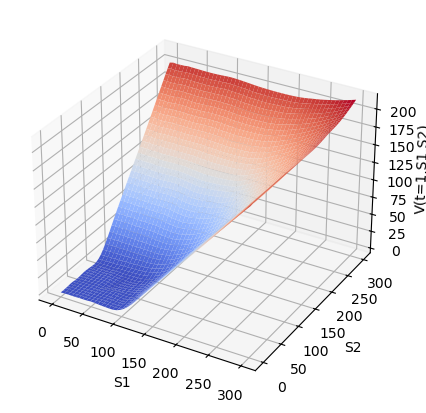

In [19]:
import matplotlib.pyplot as plt

def plot_surface1(model, t_fixed=1.0, d=2, n_grid=50):
    S1 = np.linspace(S_low, S_high, n_grid)
    S2 = np.linspace(S_low, S_high, n_grid)
    S1_grid, S2_grid = np.meshgrid(S1, S2)

    t_plot = t_fixed * np.ones_like(S1_grid)
    inputs = [t_plot.reshape(-1, 1), S1_grid.reshape(-1, 1), S2_grid.reshape(-1, 1)]

    with tf.device("/cpu:0"):  # pour éviter surchauffe GPU
        pred = model(*inputs).numpy().reshape(n_grid, n_grid)

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(S1_grid, S2_grid, pred, cmap="coolwarm")
    ax.set_xlabel("S1")
    ax.set_ylabel("S2")
    ax.set_zlabel(f"V(t={t_fixed},S1,S2)", labelpad=1)
    #ax.set_title(f"Prediction surface at t = {t_fixed}")
    plt.savefig("CH2_image_5050_T.png", dpi=300)
    plt.show()

plot_surface1(model,1,d=2)

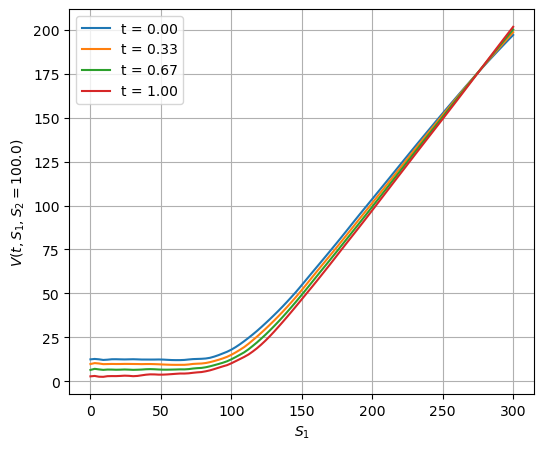

In [23]:
import matplotlib.pyplot as plt

def plot_temporal_slices(model, S2_fixed=100.0, t_list=[0, T/3, 2*T/3, T], n_points=100):
    """
    Trace V(t, S1, S2_fixed) pour plusieurs t donnés.
    """
    S1_vals = np.linspace(S_low, S_high, n_points).reshape(-1, 1)
    S2_vals = np.full_like(S1_vals, S2_fixed)

    plt.figure(figsize=(6, 5))

    for t in t_list:
        t_vals = np.full_like(S1_vals, t)
        inputs = [tf.convert_to_tensor(t_vals, dtype=tf.float32),
                  tf.convert_to_tensor(S1_vals, dtype=tf.float32),
                  tf.convert_to_tensor(S2_vals, dtype=tf.float32)]

        with tf.device("/cpu:0"):
            preds = model(*inputs).numpy()

        plt.plot(S1_vals, preds, label=f"t = {t:.2f}")

    plt.xlabel(r"$S_1$")
    plt.ylabel(r"$V(t, S_1, S_2 = %.1f)$" % S2_fixed)
    plt.legend()
    plt.grid(True)
    plt.savefig("CH2_image4_slices_5050.png", dpi=300)
    plt.show()

plot_temporal_slices(model, S2_fixed=100)

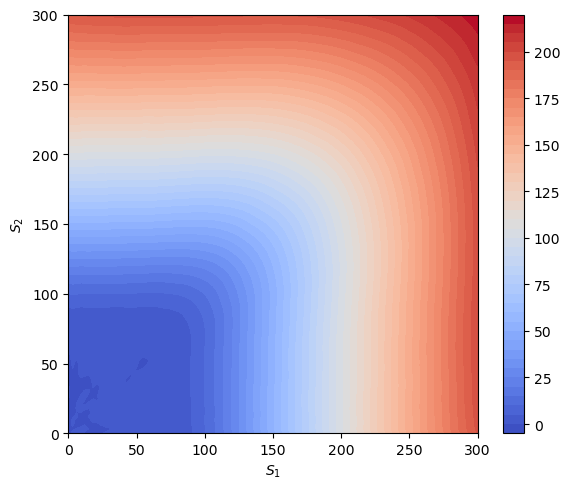

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def plot_contour_solution(model, t_fixed=1.0, n_grid=100):
    """
    Trace une heatmap 2D de la solution V(t, S1, S2) à temps fixé (par défaut maturité t=1).
    """
    S1 = np.linspace(S_low, S_high, n_grid)
    S2 = np.linspace(S_low, S_high, n_grid)
    S1_grid, S2_grid = np.meshgrid(S1, S2)

    t_vals = t_fixed * np.ones_like(S1_grid)

    # Préparation des inputs
    t_input = tf.convert_to_tensor(t_vals.reshape(-1, 1), dtype=tf.float32)
    S1_input = tf.convert_to_tensor(S1_grid.reshape(-1, 1), dtype=tf.float32)
    S2_input = tf.convert_to_tensor(S2_grid.reshape(-1, 1), dtype=tf.float32)

    # Prédiction
    with tf.device("/cpu:0"):
        V_pred = model(t_input, S1_input, S2_input).numpy().reshape(n_grid, n_grid)

    # Affichage
    plt.figure(figsize=(6, 5))
    contour = plt.contourf(S1_grid, S2_grid, V_pred, levels=50, cmap="coolwarm")
    plt.xlabel("$S_1$")
    plt.ylabel("$S_2$")
    #plt.title(f"Option value at t = {t_fixed}")
    plt.colorbar(contour)
    plt.savefig("CH2_image_2D_033_5050.png", dpi=300)
    plt.tight_layout()
    plt.show()

plot_contour_solution(model, t_fixed=0.33)

In [29]:
def plot_surface_time_vs_S1(model, S2_fixed=100.0, n_points=100):
    """
    Trace V(t, S1, S2_fixed) en surface 3D (t sur x, S1 sur y, V sur z)
    """
    t_vals = np.linspace(t_low, T, n_points)
    S1_vals = np.linspace(S_low, S_high, n_points)

    T_grid, S1_grid = np.meshgrid(t_vals, S1_vals)
    S2_grid = S2_fixed * np.ones_like(T_grid)

    t_input = tf.convert_to_tensor(T_grid.reshape(-1, 1), dtype=tf.float32)
    S1_input = tf.convert_to_tensor(S1_grid.reshape(-1, 1), dtype=tf.float32)
    S2_input = tf.convert_to_tensor(S2_grid.reshape(-1, 1), dtype=tf.float32)

    with tf.device("/cpu:0"):
        V_pred = model(t_input, S1_input, S2_input).numpy().reshape(n_points, n_points)

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(T_grid, S1_grid, V_pred, cmap="coolwarm", edgecolor="none")
    ax.set_xlabel("t")
    ax.set_ylabel("$S_1$")
    ax.set_zlabel(f"$V(t, S_1, S_2 = {S2_fixed})$",labelpad=1)
    #ax.set_title("Surface plot of option value over time and $S_1$")
    plt.savefig("CH2_S2100_5050.png", dpi=300)
    plt.tight_layout()
    plt.show()

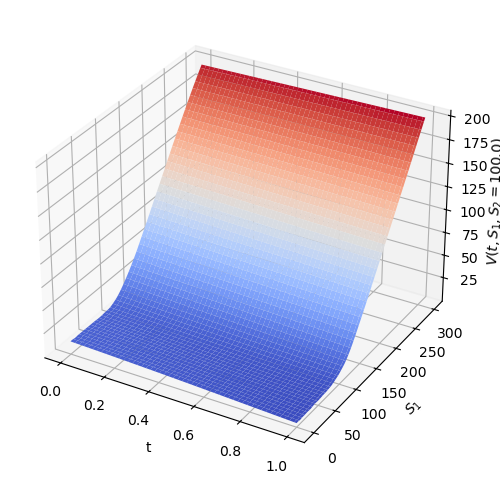

In [31]:
plot_surface_time_vs_S1(model, S2_fixed=100.0)

In [33]:
def monte_carlo_max_call(S1, S2, t, K, T, r, sigma1, sigma2, rho=0.0, n_paths=1000000, seed=42):
    np.random.seed(seed)
    dt = T - t
    S1 = np.array(S1).reshape(-1, 1)
    S2 = np.array(S2).reshape(-1, 1)
    n_samples = S1.shape[0]
    Z1 = np.random.randn(n_samples, n_paths)
    Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.randn(n_samples, n_paths)
    S1_T = S1 * np.exp((r - 0.5 * sigma1**2) * dt + sigma1 * np.sqrt(dt) * Z1)
    S2_T = S2 * np.exp((r - 0.5 * sigma2**2) * dt + sigma2 * np.sqrt(dt) * Z2)
    payoff = np.maximum(np.maximum(S1_T, S2_T) - K, 0)
    return np.exp(-r * dt) * np.mean(payoff, axis=1)

# Grille S1/S2
n_grid = 50
S1_vals = np.linspace(S_low, S_high, n_grid)
S2_vals = np.linspace(S_low, S_high, n_grid)
S1_grid, S2_grid = np.meshgrid(S1_vals, S2_vals)
S1_flat = S1_grid.flatten()
S2_flat = S2_grid.flatten()

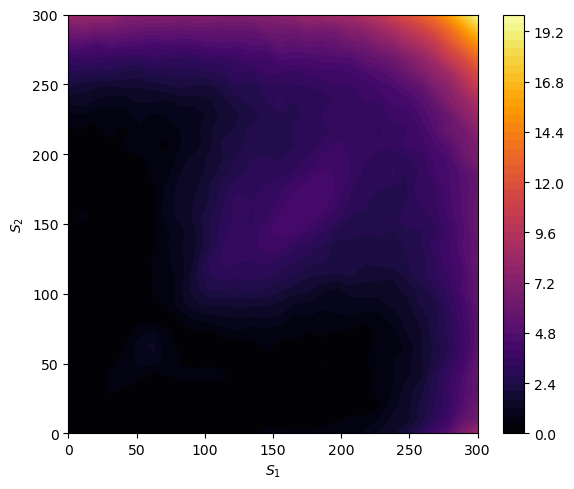

,0.00,10.34,20.69,31.03,41.38,51.72,62.07,72.41,82.76,93.10,...,206.90,217.24,227.59,237.93,248.28,258.62,268.97,279.31,289.66,300.00
0.00,0.183437,0.079787,0.055252,0.195834,0.241503,0.207737,0.083557,0.036765,0.058964,0.169501,...,0.622842,0.867537,1.209649,1.497248,2.003269,2.843721,3.948173,4.975298,6.867561,8.390099
10.34,0.374978,0.199864,0.163505,0.121801,0.033516,0.047042,0.070762,0.176599,0.099289,0.019245,...,0.442982,0.511334,0.761852,1.278296,1.440250,2.170533,3.069075,3.908009,5.426110,6.202895
20.69,0.056102,0.051796,0.005528,0.050167,0.066076,0.193587,0.069707,0.144898,0.100431,0.153540,...,0.089001,0.080486,0.297808,1.025283,1.408513,2.085293,2.810049,3.542779,4.796861,5.985847
31.03,0.093928,0.032489,0.087384,0.474729,0.322054,0.076277,0.146913,0.139841,0.203447,0.241774,...,0.160592,0.210191,0.631899,0.812789,1.400156,1.849166,2.677789,3.547251,4.651573,5.465759
41.38,0.120540,0.112075,0.118484,0.469987,0.585327,0.636970,0.188748,0.401015,0.479149,0.477861,...,0.192009,0.155395,0.614756,0.760564,1.110430,1.433611,2.618349,3.455426,4.448080,5.740709
51.72,0.162414,0.071250,0.079935,0.275746,0.520936,0.900100,0.937826,0.648798,0.362273,0.311093,...,0.363929,0.333979,0.527014,0.770319,1.035359,1.539993,2.194707,3.109358,3.966999,5.414799
62.07,0.022169,0.070932,0.024311,0.088236,0.338745,0.995554,1.325309,0.538189,0.298923,0.171196,...,0.292492,0.351295,0.456901,0.665646,0.829704,1.598844,2.110613,2.763855,3.753833,5.146246
72.41,0.038746,0.120799,0.056051,0.043904,0.044842,0.643637,0.910997,0.477293,0.156758,0.362720,...,0.293897,0.135616,0.540566,0.655493,1.213508,1.564319,2.330766,3.030254,3.815807,5.067171
82.76,0.041817,0.036485,0.085058,0.181663,0.092740,0.259441,0.159130,0.064523,0.506413,0.882547,...,0.790685,0.573861,0.668609,0.935952,1.381615,1.699010,2.274993,2.977763,3.980474,5.076851
93.10,0.127721,0.068882,0.101004,0.280055,0.058213,0.023625,0.313971,0.468909,1.112438,1.498375,...,0.917857,0.988471,1.034919,1.310321,1.504748,2.071089,2.313791,3.229330,4.046286,5.347689


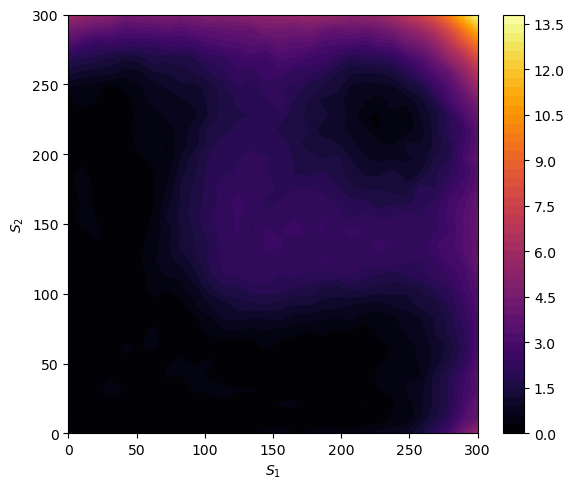

,0.00,10.34,20.69,31.03,41.38,51.72,62.07,72.41,82.76,93.10,...,206.90,217.24,227.59,237.93,248.28,258.62,268.97,279.31,289.66,300.00
0.00,0.304411,0.024494,0.079062,0.113387,0.187095,0.259197,0.044836,0.033906,0.024819,0.107633,...,0.381500,0.523523,0.698217,0.786237,1.002501,1.460823,2.133642,2.825762,4.362064,5.642437
10.34,0.318353,0.207811,0.144947,0.141032,0.097301,0.044375,0.010117,0.043342,0.078427,0.079233,...,0.018470,0.042418,0.046572,0.370890,0.381950,0.882799,1.517541,2.093603,3.246165,3.862896
20.69,0.070859,0.025527,0.116403,0.013398,0.021747,0.059418,0.030671,0.055183,0.120125,0.140303,...,0.226736,0.309966,0.141787,0.276257,0.401383,0.821156,1.305981,1.809595,2.797301,3.763971
31.03,0.084574,0.065468,0.149571,0.490392,0.257782,0.025503,0.116614,0.065744,0.204854,0.332763,...,0.299789,0.015249,0.288536,0.318136,0.629031,0.818119,1.321172,1.873569,2.666667,3.307482
41.38,0.220724,0.060649,0.114644,0.223033,0.208459,0.231701,0.101348,0.330308,0.294276,0.362307,...,0.015347,0.016443,0.406247,0.455353,0.561860,0.577918,1.293605,1.776695,2.454784,3.456454
51.72,0.177957,0.111962,0.089354,0.272716,0.285505,0.027808,0.129308,0.275889,0.315471,0.252411,...,0.098038,0.112221,0.232694,0.355346,0.439072,0.665442,0.973420,1.502638,2.041597,3.144252
62.07,0.025835,0.114534,0.064080,0.158666,0.322039,0.277629,0.351611,0.182658,0.267059,0.034381,...,0.037660,0.156595,0.222834,0.326163,0.325929,0.756954,0.963039,1.286095,1.898662,2.905147
72.41,0.065605,0.027576,0.009866,0.034460,0.092134,0.171277,0.399873,0.163405,0.003056,0.190900,...,0.217277,0.079133,0.330730,0.327415,0.651503,0.763406,1.201386,1.570987,2.018060,2.870521
82.76,0.028062,0.035588,0.023096,0.004002,0.074356,0.140791,0.111713,0.114794,0.161902,0.265764,...,0.642433,0.413921,0.428060,0.532708,0.778847,0.890911,1.225762,1.635485,2.243954,2.910179
93.10,0.118040,0.066614,0.114036,0.104467,0.094521,0.044406,0.235511,0.067862,0.235939,0.591494,...,0.929223,0.874383,0.813345,0.951839,1.014407,1.346976,1.370936,1.893587,2.337634,3.168708


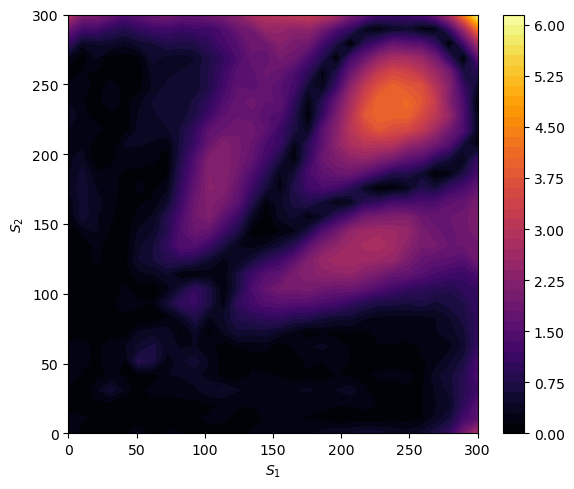

,0.00,10.34,20.69,31.03,41.38,51.72,62.07,72.41,82.76,93.10,...,206.90,217.24,227.59,237.93,248.28,258.62,268.97,279.31,289.66,300.00
0.00,0.314193,0.010306,0.142597,0.109162,0.093204,0.310790,0.052385,0.178252,0.155585,0.072503,...,0.455590,0.536297,0.529596,0.406076,0.362723,0.474044,0.714582,0.990942,1.927503,2.761136
10.34,0.242811,0.182164,0.122529,0.153617,0.086684,0.000540,0.071505,0.025311,0.005693,0.117066,...,0.035563,0.022675,0.017323,0.105356,0.066595,0.106496,0.357436,0.585238,1.248088,1.571207
20.69,0.060098,0.053518,0.113966,0.029225,0.033126,0.002212,0.009061,0.118743,0.117717,0.086972,...,0.167725,0.220377,0.131975,0.085178,0.008631,0.122365,0.276976,0.414729,0.935426,1.499978
31.03,0.105081,0.004602,0.261345,0.551013,0.261939,0.004940,0.263515,0.166973,0.189130,0.274760,...,0.384330,0.182091,0.026346,0.010874,0.112179,0.124224,0.311940,0.495404,0.850220,1.148811
41.38,0.327561,0.085506,0.094124,0.170597,0.134623,0.070487,0.045094,0.297976,0.306291,0.375624,...,0.118495,0.086625,0.218596,0.222474,0.194598,0.062792,0.399303,0.554691,0.833355,1.378262
51.72,0.126459,0.231282,0.081335,0.287465,0.131529,0.802155,0.675261,0.177698,0.421296,0.522161,...,0.111721,0.054635,0.005405,0.043711,0.033904,0.117613,0.216556,0.419855,0.636213,1.268843
62.07,0.173831,0.216054,0.081403,0.256503,0.277114,0.480366,0.637747,0.386824,0.276861,0.305370,...,0.139406,0.035718,0.115243,0.148376,0.033532,0.173608,0.166521,0.239077,0.488500,1.041193
72.41,0.122332,0.022398,0.090557,0.014738,0.038027,0.336526,0.398558,0.373387,0.079554,0.378793,...,0.134500,0.090703,0.243823,0.163602,0.272048,0.173757,0.287902,0.371107,0.539832,0.996037
82.76,0.014616,0.070207,0.079125,0.084099,0.099316,0.033276,0.000872,0.153692,0.385546,0.728843,...,0.502237,0.316320,0.258885,0.206480,0.264292,0.200191,0.300358,0.438597,0.676438,0.947960
93.10,0.019135,0.045973,0.070372,0.081790,0.259454,0.170202,0.153829,0.574001,1.007044,1.091431,...,0.974042,0.799634,0.658771,0.655286,0.592488,0.694575,0.535631,0.666898,0.730693,1.060526


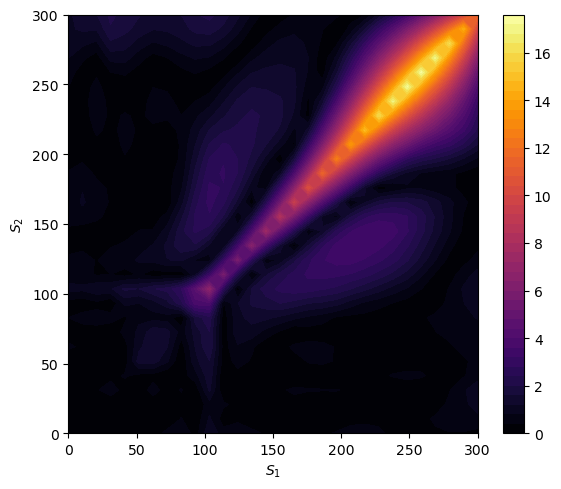

,0.00,10.34,20.69,31.03,41.38,51.72,62.07,72.41,82.76,93.10,...,206.90,217.24,227.59,237.93,248.28,258.62,268.97,279.31,289.66,300.00
0.00,0.298163,0.035787,0.180924,0.120980,0.021671,0.306874,0.181313,0.544166,0.802077,0.197275,...,0.648067,0.705330,0.522283,0.212302,0.031884,0.209003,0.318916,0.375167,0.364800,0.222115
10.34,0.142277,0.165870,0.059570,0.094772,0.030537,0.055934,0.207318,0.024455,0.419245,0.088353,...,0.191843,0.231402,0.247842,0.171713,0.017273,0.234841,0.481943,0.625373,0.705561,0.745213
20.69,0.125154,0.111794,0.133955,0.095772,0.055226,0.008923,0.134094,0.173600,0.247564,0.006231,...,0.020566,0.148719,0.228199,0.262994,0.193819,0.039483,0.189258,0.490588,0.750101,0.896565
31.03,0.148136,0.039661,0.356432,0.605390,0.238654,0.134621,0.585654,0.201671,0.430269,0.118561,...,0.332324,0.177082,0.008164,0.125741,0.185466,0.143881,0.041815,0.372550,0.748723,1.034908
41.38,0.366347,0.035417,0.109367,0.276048,0.443497,0.287500,0.237057,0.047736,0.208335,0.640818,...,0.032840,0.117424,0.299816,0.430015,0.490947,0.447524,0.278278,0.005327,0.351716,0.660522
51.72,0.013280,0.309900,0.039200,0.353642,0.125529,1.373453,1.402907,0.868053,0.021162,1.084672,...,0.165153,0.003787,0.096730,0.158842,0.202749,0.254463,0.197400,0.031234,0.315571,0.565685
62.07,0.489646,0.304690,0.095780,0.361534,0.200377,1.100968,1.524538,1.224498,0.190317,1.228529,...,0.170152,0.077610,0.259847,0.297687,0.198262,0.007290,0.156606,0.329441,0.556174,0.714003
72.41,0.153731,0.152817,0.255928,0.037033,0.543393,0.877523,1.472370,1.357739,0.585614,1.354939,...,0.022755,0.202360,0.289958,0.239143,0.097197,0.142791,0.385300,0.527854,0.607465,0.688699
82.76,0.401899,0.581246,0.550763,0.599357,0.319393,0.730291,0.651049,0.600910,0.066876,1.770293,...,0.258029,0.251819,0.183429,0.002203,0.163594,0.334731,0.485318,0.614810,0.735821,0.814427
93.10,0.223866,0.103858,0.288914,0.032448,0.902990,0.789981,1.001519,1.442515,2.269486,3.796614,...,0.997159,0.701015,0.526193,0.384631,0.216399,0.042153,0.198326,0.508436,0.788030,0.990933


In [45]:
import pandas as pd

for i, t_fixed in enumerate([0.0, T/3, 2*T/3, T]):
    # Monte Carlo
    V_MC_flat = monte_carlo_max_call(S1_flat, S2_flat, t_fixed, K, T, r, sigma1, sigma2, rho, 100000)

    # PINN
    t_tensor = tf.convert_to_tensor(np.full_like(S1_flat, t_fixed).reshape(-1, 1), dtype=tf.float32)
    S1_tensor = tf.convert_to_tensor(S1_flat.reshape(-1, 1), dtype=tf.float32)
    S2_tensor = tf.convert_to_tensor(S2_flat.reshape(-1, 1), dtype=tf.float32)
    V_PINN_flat = model(t_tensor, S1_tensor, S2_tensor).numpy().flatten()

    abs_error = np.abs(V_MC_flat - V_PINN_flat).reshape(n_grid, n_grid)

    # Heatmap
    plt.figure(figsize=(6, 5))
    plt.contourf(S1_grid, S2_grid, abs_error, levels=50, cmap="inferno")
    plt.colorbar()
    plt.xlabel("$S_1$")
    plt.ylabel("$S_2$")
    plt.tight_layout()
    plt.savefig(f"CH2_image_5050_ERROR_{8+i}4.png", dpi=300)
    plt.show()

    # Tableau d'erreur
    df_error = pd.DataFrame(abs_error, index=np.round(S2_vals, 2), columns=np.round(S1_vals, 2))
    display(df_error)

    # Sauvegarde Excel
    df_error.to_excel(f"CH2_error_table_5050_{8+i}4.xlsx")